#### Human activity recognition feature representations with convolutional autoencoder

The model architecture and feature engineering methods from the following paper are implemented

[On the Role of Features in HAR](https://dl.acm.org/doi/10.1145/3341163.3347727)

Classification: probabilistic classification with MLP

In [2]:
import torch
import os
import pandas as pd
import json

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR


import csv
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import sys
module_dir = "../modules"
if module_dir not in sys.path:
    sys.path.append(module_dir)
    
from frame_dataloader_heavy import WorkloadFrame
from convolutional_autoencoder import ConvAE
import utils

#### Cognitive/Physical workload Dataset

Input: consists of individual frames of length context_length * signal_length


In [4]:
# retrieve 1-second frames from csv 

b_size = 64
n_workers = utils.optimal_num_workers()

# directory to .mat files
dir='..\\files\\'

#  file group: 'phys', 'cog', or 'tot'
group='phys'

# signal channel to resample to: 'temp', 'hrv, 'hr', 'hbo', 'eda'
resample='temp'

# size of sliding window relative to shortest signal length; always 50% overlap between windows
context_length=0.5

frames = WorkloadFrame(dir=dir, group=group, resample=resample, context_length=context_length)

# split 'frames' dataset into train, val, and test
g = torch.Generator().manual_seed(7)

frames_trainset, frames_valset, frames_testset = random_split(frames, [0.8, 0.1, 0.1], generator=g)

frames_trainloader = DataLoader(frames_trainset, batch_size=b_size, num_workers=n_workers,pin_memory=torch.cuda.is_available(),persistent_workers=True, prefetch_factor=4)
frames_valloader = DataLoader(frames_valset, batch_size=b_size, num_workers=n_workers,pin_memory=torch.cuda.is_available(),persistent_workers=True, prefetch_factor=4)
frames_testloader = DataLoader(frames_testset, batch_size=b_size, num_workers=n_workers,pin_memory=torch.cuda.is_available(),persistent_workers=True, prefetch_factor=4)



Using 4 workers (CPU cores: 8, Available RAM: 0.44GB)


In [5]:
frames_trainset.__len__()

3047

In [6]:
frames_trainset.__getitem__(0)[0].shape

torch.Size([1, 129, 5])

#### Probing

In [22]:
# locate device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_channels = 1
cout = 3

input_tensor = frames_trainset.__getitem__(0)[0].unsqueeze(0).to(device)


conv = nn.Conv2d(num_channels, cout, kernel_size=(3, 3), padding=(1, 1), device=device)
batchnorm = nn.BatchNorm2d(cout, device=device)

activation_map = conv(input_tensor)
n_activation_map = batchnorm(activation_map)

input_tensor.shape, activation_map.shape, n_activation_map.shape


(torch.Size([1, 1, 5, 129]),
 torch.Size([1, 3, 5, 129]),
 torch.Size([1, 3, 5, 129]))

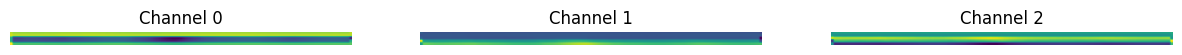

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    axes[i].imshow(activation_map.cpu().detach().numpy()[0, i, :, :])
    axes[i].set_title(f"Channel {i}")
    axes[i].axis("off")  

plt.show()

In [24]:
activation_map[0, 0, :, :]

tensor([[ -15.8935,  -35.2172,  -33.9146,  -34.8315,  -35.1869,  -34.7275,
          -35.5010,  -35.1993,  -35.1323,  -35.6149,  -35.0675,  -35.9079,
          -35.6139,  -33.1536,  -33.4540,  -34.2205,  -34.3674,  -34.2301,
          -32.7509,  -30.2770,  -30.2010,  -30.1902,  -29.7715,  -30.1736,
          -29.6348,  -30.0606,  -30.1935,  -28.9221,  -29.0505,  -28.8545,
          -28.8215,  -28.9958,  -28.4117,  -29.8608,  -30.3823,  -31.1400,
          -32.1157,  -31.5871,  -32.7816,  -33.2946,  -34.3118,  -35.4332,
          -34.4665,  -35.5002,  -36.5288,  -36.0917,  -37.2191,  -37.6684,
          -37.2323,  -38.0810,  -38.2334,  -37.1262,  -37.8418,  -38.2888,
          -36.9171,  -37.5723,  -38.2725,  -37.1764,  -35.9412,  -36.6345,
          -36.8824,  -35.4497,  -35.6416,  -36.2407,  -35.3252,  -33.2384,
          -33.1572,  -33.1979,  -31.3822,  -31.4095,  -31.5764,  -30.2171,
          -30.2093,  -30.4483,  -29.3121,  -29.4878,  -29.7241,  -28.7253,
          -28.6938,  -28.

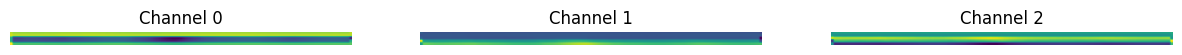

In [25]:
# batchnormed activation map
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    axes[i].imshow(n_activation_map.cpu().detach().numpy()[0, i, :, :])
    axes[i].set_title(f"Channel {i}")
    axes[i].axis("off")  

plt.show()

In [26]:
n_activation_map[0, 0, :, :]

tensor([[ 1.0008,  0.8550,  0.8649,  0.8580,  0.8553,  0.8587,  0.8529,  0.8552,
          0.8557,  0.8520,  0.8562,  0.8498,  0.8521,  0.8706,  0.8683,  0.8626,
          0.8615,  0.8625,  0.8736,  0.8923,  0.8929,  0.8930,  0.8961,  0.8931,
          0.8971,  0.8939,  0.8929,  0.9025,  0.9015,  0.9030,  0.9033,  0.9020,
          0.9064,  0.8954,  0.8915,  0.8858,  0.8784,  0.8824,  0.8734,  0.8695,
          0.8619,  0.8534,  0.8607,  0.8529,  0.8452,  0.8484,  0.8399,  0.8366,
          0.8398,  0.8334,  0.8323,  0.8406,  0.8353,  0.8319,  0.8422,  0.8373,
          0.8320,  0.8403,  0.8496,  0.8444,  0.8425,  0.8533,  0.8518,  0.8473,
          0.8542,  0.8700,  0.8706,  0.8703,  0.8840,  0.8838,  0.8825,  0.8927,
          0.8928,  0.8910,  0.8996,  0.8982,  0.8965,  0.9040,  0.9042,  0.9054,
          0.9085,  0.9069,  0.9093,  0.9032,  0.8925,  0.9012,  0.9013,  0.9036,
          0.9034,  0.9010,  0.9049,  0.9000,  0.8967,  0.8881,  0.8808,  0.8808,
          0.8748,  0.8741,  

In [27]:
# the batchnorm2d module normalizes each channel of activation map to have 0 mean and 1 standard deviation (e.g normalizes across W*H dimension)
torch.mean(n_activation_map[0, 0, :, :]), torch.std(n_activation_map[0, 0, :, :])

(tensor(-3.8443e-08, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.0008, device='cuda:0', grad_fn=<StdBackward0>))

In [38]:
# reading existing logs for continous updating
df = pd.read_csv("..\\saved_models\\convolutional_autoencoder\\conv_ae_9374595.csv")
list(df.T.to_dict().values())

[{'Epoch': 1.0,
  'Training Loss': 1.0037,
  'Validation Loss': 1.0442,
  'Learning Rate': 0.001},
 {'Epoch': 2.0,
  'Training Loss': 0.9987,
  'Validation Loss': 1.0477,
  'Learning Rate': 0.001},
 {'Epoch': 3.0,
  'Training Loss': 0.9979,
  'Validation Loss': 1.0477,
  'Learning Rate': 0.001},
 {'Epoch': 4.0,
  'Training Loss': 0.9979,
  'Validation Loss': 1.0475,
  'Learning Rate': 0.001},
 {'Epoch': 5.0,
  'Training Loss': 0.9954,
  'Validation Loss': 1.0349,
  'Learning Rate': 0.001},
 {'Epoch': 6.0,
  'Training Loss': 0.9765,
  'Validation Loss': 1.0195,
  'Learning Rate': 0.001},
 {'Epoch': 7.0,
  'Training Loss': 0.9631,
  'Validation Loss': 0.9986,
  'Learning Rate': 0.001},
 {'Epoch': 8.0,
  'Training Loss': 0.9403,
  'Validation Loss': 0.9913,
  'Learning Rate': 0.001},
 {'Epoch': 9.0,
  'Training Loss': 0.9278,
  'Validation Loss': 0.9815,
  'Learning Rate': 0.001},
 {'Epoch': 10.0,
  'Training Loss': 0.9219,
  'Validation Loss': 0.9769,
  'Learning Rate': 0.001},
 {'Epoch'

#### Convolutional Autoencoder

In [ ]:
# TODO: make this stuff modular and less error prone (e.g resetting model parameters accidentally)

In [9]:
# load model architecture

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dim=2084
c = [1, 64, 128, 256, 512]

conv_ae = ConvAE(latent_dim=dim, channels=c, kernel=(3, 2))
conv_ae.to(device);

In [12]:
model_filepath = "..\\saved_models\\convolutional_autoencoder\\"

model_name = f'conv_ae_{utils.num_parameters(conv_ae)}'


meta_data = {
    'model name':model_name,
    'learning rate':1e-3,
    'optimizer':'Adam',
    'latent dim': 2084,
    'channel sizes': c,
    'kernel size':(3, 2)
}

with open(model_filepath+model_name+'.json', 'w') as file:
    json.dump(meta_data, file, indent=4)


In [13]:
# initialise model architecture with forward pass (this needs to be fixed :c )
with torch.no_grad():
    sample_input = frames_trainset.__getitem__(0)[0].unsqueeze(0).to(device)
    sample_output = conv_ae(sample_input)
    loss = F.mse_loss(sample_input, sample_output, reduction='mean')

sample_input.shape, sample_output.shape, loss.item()

(torch.Size([1, 1, 129, 5]), torch.Size([1, 1, 129, 5]), 1.1089777946472168)

In [14]:
# check for existing state dicts

if f'{model_name}.pth' in os.listdir(model_filepath):
    conv_ae.load_state_dict(torch.load(model_filepath+model_name+'.pth'))
    print(f'Loaded state dict for {model_name}')
else:
    print(f'No saved weights found for {model_name} in {model_filepath}')

No saved weights found for conv_ae_40428143 in ..\saved_models\convolutional_autoencoder\


In [11]:
# check for existing logs

if f'{model_name}.csv' in os.listdir(model_filepath):
    df = pd.read_csv(model_filepath+model_name+'.csv')
    log = list(df.T.to_dict().values())
    print(f'Existing log data found for {len(log)} epochs')
else:
    log = []
    print(f'No existing log data found for {model_name} in {model_filepath}. Creating new one')

Existing log data found for 202 epochs


In [21]:
# one time parameters

def loss_function(y, y_hat, red='mean'):
    return F.mse_loss(y, y_hat, reduction=red)

activation_stats = {}

def forward_hook(module, input, output):
    if conv_ae.log_stats:
        activation_stats[module] = {
            "mean": output.mean().item(),
            "std": output.std().item()
        }

for name, layer in conv_ae.named_modules(remove_duplicate=True):
    layer.register_forward_hook(forward_hook)

In [13]:
device, model_filepath, model_name

(device(type='cuda', index=0),
 '..\\saved_models\\convolutional_autoencoder\\',
 'conv_ae_6253059')

In [14]:
# parameters tunable during training

epochs = 150
patience = 10
best_val_loss = float('inf')
epochs_without_improvement = 0
optimizer = optim.Adam(conv_ae.parameters(), lr=1e-3)

step_lr = StepLR(optimizer, step_size=50, gamma=0.1)
cos_lr = CosineAnnealingLR(optimizer, T_max=epochs//10, eta_min=0)

scheduler = step_lr

#### Autoencoder Training Loop

In [55]:
for e in range(epochs):
    conv_ae.train()
    train_loss = 0.0
    for data, _ in tqdm(frames_trainloader, desc=f"Epoch {e+1}/{epochs} [Training]", leave=False):
        data = data.to(device)

        optimizer.zero_grad()
        recon_data = conv_ae(data)
        loss = loss_function(recon_data, data, red='mean')
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    scheduler.step()

    conv_ae.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, _ in tqdm(frames_trainloader, desc=f"Epoch {e+1}/{epochs} [Validation]", leave=False):
            data = data.to(device)
            recon_data = conv_ae(data)
            loss = loss_function(recon_data, data, red='mean')

            val_loss += loss.item()

    # average losses
    train_loss /= len(frames_trainloader)
    val_loss /= len(frames_trainloader)

    print(f"Epoch {e+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    log.append({'Epoch':e+1, 'Training Loss':round(train_loss, 4), 'Validation Loss':round(val_loss, 4), 'Learning Rate':scheduler.get_last_lr()[0]})

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        epochs_without_improvement = 0
        best_val_loss = 0.0
        print(f'Plateaued at {e+1}, switching to cosine annealing ')
        scheduler = cos_lr

    if e % 5 == 0:
        torch.save(conv_ae.state_dict(), model_filepath + model_name + '.pth')
        loss_data = pd.DataFrame(log)
        loss_data.to_csv(model_filepath+model_name+'.csv', index=False)


torch.save(conv_ae.state_dict(), model_filepath + model_name + '.pth')
loss_data = pd.DataFrame(log)
loss_data.to_csv(model_filepath+model_name+'.csv', index=False)

Epoch 1/150, Train Loss: 0.3967, Val Loss: 0.3931


Epoch 2/150, Train Loss: 0.3938, Val Loss: 0.3930


Epoch 3/150, Train Loss: 0.3929, Val Loss: 0.3935


Epoch 4/150, Train Loss: 0.3925, Val Loss: 0.3949


Epoch 5/150, Train Loss: 0.3934, Val Loss: 0.3944


Epoch 6/150, Train Loss: 0.3927, Val Loss: 0.3951


Epoch 7/150, Train Loss: 0.3923, Val Loss: 0.3936


Epoch 8/150, Train Loss: 0.3927, Val Loss: 0.3947


Epoch 9/150, Train Loss: 0.3925, Val Loss: 0.3937


Epoch 10/150, Train Loss: 0.3928, Val Loss: 0.3969


Epoch 11/150, Train Loss: 0.3936, Val Loss: 0.3992


Epoch 12/150, Train Loss: 0.3941, Val Loss: 0.3979
Plateaued at 12, switching to cosine annealing 


Epoch 13/150, Train Loss: 0.3929, Val Loss: 0.3969


Epoch 14/150, Train Loss: 0.3923, Val Loss: 0.3946


Epoch 15/150, Train Loss: 0.3911, Val Loss: 0.3926


Epoch 16/150, Train Loss: 0.3898, Val Loss: 0.3904


Epoch 17/150, Train Loss: 0.3893, Val Loss: 0.3910


Epoch 18/150, Train Loss: 0.3889, Val Loss: 0.3913


Epoch 19/150, Train Loss: 0.3887, Val Loss: 0.3903


Epoch 20/150, Train Loss: 0.3878, Val Loss: 0.3901


Epoch 21/150, Train Loss: 0.3864, Val Loss: 0.3865


Epoch 22/150, Train Loss: 0.3854, Val Loss: 0.3857
Plateaued at 22, switching to cosine annealing 


Epoch 23/150, Train Loss: 0.3848, Val Loss: 0.3836


Epoch 24/150, Train Loss: 0.3842, Val Loss: 0.3834


Epoch 25/150, Train Loss: 0.3835, Val Loss: 0.3827


Epoch 26/150, Train Loss: 0.3827, Val Loss: 0.3823


Epoch 27/150, Train Loss: 0.3824, Val Loss: 0.3822


Epoch 28/150, Train Loss: 0.3823, Val Loss: 0.3822


Epoch 29/150, Train Loss: 0.3824, Val Loss: 0.3822


Epoch 30/150, Train Loss: 0.3825, Val Loss: 0.3822


Epoch 31/150, Train Loss: 0.3827, Val Loss: 0.3825


Epoch 32/150, Train Loss: 0.3828, Val Loss: 0.3824
Plateaued at 32, switching to cosine annealing 


Epoch 33/150, Train Loss: 0.3827, Val Loss: 0.3825


Epoch 34/150, Train Loss: 0.3825, Val Loss: 0.3829


Epoch 35/150, Train Loss: 0.3823, Val Loss: 0.3831


Epoch 36/150, Train Loss: 0.3824, Val Loss: 0.3830


Epoch 37/150, Train Loss: 0.3828, Val Loss: 0.3845


Epoch 38/150, Train Loss: 0.3841, Val Loss: 0.3851


Epoch 39/150, Train Loss: 0.3842, Val Loss: 0.3853


Epoch 40/150, Train Loss: 0.3847, Val Loss: 0.3854


Epoch 41/150, Train Loss: 0.3843, Val Loss: 0.3862


Epoch 42/150, Train Loss: 0.3843, Val Loss: 0.3849
Plateaued at 42, switching to cosine annealing 


Epoch 43/150, Train Loss: 0.3857, Val Loss: 0.3880


Epoch 44/150, Train Loss: 0.3862, Val Loss: 0.3882


Epoch 45/150, Train Loss: 0.3865, Val Loss: 0.3898


Epoch 46/150, Train Loss: 0.3848, Val Loss: 0.3870


Epoch 47/150, Train Loss: 0.3837, Val Loss: 0.3849


Epoch 48/150, Train Loss: 0.3831, Val Loss: 0.3848


Epoch 49/150, Train Loss: 0.3828, Val Loss: 0.3866


Epoch 50/150, Train Loss: 0.3828, Val Loss: 0.3843


Epoch 51/150, Train Loss: 0.3815, Val Loss: 0.3820


Epoch 52/150, Train Loss: 0.3804, Val Loss: 0.3806
Plateaued at 52, switching to cosine annealing 


Epoch 53/150, Train Loss: 0.3798, Val Loss: 0.3793


Epoch 54/150, Train Loss: 0.3793, Val Loss: 0.3790


Epoch 55/150, Train Loss: 0.3786, Val Loss: 0.3782


Epoch 56/150, Train Loss: 0.3779, Val Loss: 0.3780


Epoch 57/150, Train Loss: 0.3776, Val Loss: 0.3779


Epoch 58/150, Train Loss: 0.3775, Val Loss: 0.3779


Epoch 59/150, Train Loss: 0.3776, Val Loss: 0.3779


Epoch 60/150, Train Loss: 0.3777, Val Loss: 0.3779


Epoch 61/150, Train Loss: 0.3779, Val Loss: 0.3780


Epoch 62/150, Train Loss: 0.3780, Val Loss: 0.3780
Plateaued at 62, switching to cosine annealing 


Epoch 63/150, Train Loss: 0.3779, Val Loss: 0.3780


Epoch 64/150, Train Loss: 0.3776, Val Loss: 0.3782


Epoch 65/150, Train Loss: 0.3773, Val Loss: 0.3785


Epoch 66/150, Train Loss: 0.3772, Val Loss: 0.3792


Epoch 67/150, Train Loss: 0.3775, Val Loss: 0.3797


Epoch 68/150, Train Loss: 0.3789, Val Loss: 0.3824


Epoch 69/150, Train Loss: 0.3810, Val Loss: 0.3847


Epoch 70/150, Train Loss: 0.3817, Val Loss: 0.3833


Epoch 71/150, Train Loss: 0.3819, Val Loss: 0.3839


Epoch 72/150, Train Loss: 0.3822, Val Loss: 0.3835
Plateaued at 72, switching to cosine annealing 


Epoch 73/150, Train Loss: 0.3822, Val Loss: 0.3817


Epoch 74/150, Train Loss: 0.3812, Val Loss: 0.3812


Epoch 75/150, Train Loss: 0.3811, Val Loss: 0.3837


Epoch 76/150, Train Loss: 0.3805, Val Loss: 0.3833


Epoch 77/150, Train Loss: 0.3801, Val Loss: 0.3816


Epoch 78/150, Train Loss: 0.3789, Val Loss: 0.3810


Epoch 79/150, Train Loss: 0.3786, Val Loss: 0.3813


Epoch 80/150, Train Loss: 0.3785, Val Loss: 0.3799


Epoch 81/150, Train Loss: 0.3777, Val Loss: 0.3787


Epoch 82/150, Train Loss: 0.3770, Val Loss: 0.3776
Plateaued at 82, switching to cosine annealing 


Epoch 83/150, Train Loss: 0.3765, Val Loss: 0.3767


Epoch 84/150, Train Loss: 0.3762, Val Loss: 0.3763


Epoch 85/150, Train Loss: 0.3756, Val Loss: 0.3756


Epoch 86/150, Train Loss: 0.3749, Val Loss: 0.3753


Epoch 87/150, Train Loss: 0.3746, Val Loss: 0.3752


Epoch 88/150, Train Loss: 0.3745, Val Loss: 0.3751


Epoch 89/150, Train Loss: 0.3745, Val Loss: 0.3751


Epoch 90/150, Train Loss: 0.3746, Val Loss: 0.3752


Epoch 91/150, Train Loss: 0.3748, Val Loss: 0.3753


Epoch 92/150, Train Loss: 0.3748, Val Loss: 0.3753
Plateaued at 92, switching to cosine annealing 


Epoch 93/150, Train Loss: 0.3747, Val Loss: 0.3753


Epoch 94/150, Train Loss: 0.3745, Val Loss: 0.3754


Epoch 95/150, Train Loss: 0.3742, Val Loss: 0.3754


Epoch 96/150, Train Loss: 0.3740, Val Loss: 0.3754


Epoch 97/150, Train Loss: 0.3740, Val Loss: 0.3757


Epoch 98/150, Train Loss: 0.3743, Val Loss: 0.3762


Epoch 99/150, Train Loss: 0.3754, Val Loss: 0.3789


Epoch 100/150, Train Loss: 0.3773, Val Loss: 0.3811


Epoch 101/150, Train Loss: 0.3795, Val Loss: 0.3815


Epoch 102/150, Train Loss: 0.3810, Val Loss: 0.3803
Plateaued at 102, switching to cosine annealing 


Epoch 103/150, Train Loss: 0.3801, Val Loss: 0.3821


Epoch 104/150, Train Loss: 0.3787, Val Loss: 0.3790


Epoch 105/150, Train Loss: 0.3783, Val Loss: 0.3802


Epoch 106/150, Train Loss: 0.3778, Val Loss: 0.3794


Epoch 107/150, Train Loss: 0.3774, Val Loss: 0.3792


Epoch 108/150, Train Loss: 0.3770, Val Loss: 0.3787


Epoch 109/150, Train Loss: 0.3760, Val Loss: 0.3767


Epoch 110/150, Train Loss: 0.3751, Val Loss: 0.3762


Epoch 111/150, Train Loss: 0.3744, Val Loss: 0.3759


Epoch 112/150, Train Loss: 0.3741, Val Loss: 0.3754
Plateaued at 112, switching to cosine annealing 


Epoch 113/150, Train Loss: 0.3741, Val Loss: 0.3746


Epoch 114/150, Train Loss: 0.3738, Val Loss: 0.3740


Epoch 115/150, Train Loss: 0.3731, Val Loss: 0.3738


Epoch 116/150, Train Loss: 0.3725, Val Loss: 0.3734


Epoch 117/150, Train Loss: 0.3723, Val Loss: 0.3732


Epoch 118/150, Train Loss: 0.3721, Val Loss: 0.3731


Epoch 119/150, Train Loss: 0.3722, Val Loss: 0.3731


Epoch 120/150, Train Loss: 0.3723, Val Loss: 0.3734


Epoch 121/150, Train Loss: 0.3724, Val Loss: 0.3734


Epoch 122/150, Train Loss: 0.3724, Val Loss: 0.3732
Plateaued at 122, switching to cosine annealing 


Epoch 123/150, Train Loss: 0.3724, Val Loss: 0.3733


Epoch 124/150, Train Loss: 0.3721, Val Loss: 0.3734


Epoch 125/150, Train Loss: 0.3718, Val Loss: 0.3733


Epoch 126/150, Train Loss: 0.3716, Val Loss: 0.3734


Epoch 127/150, Train Loss: 0.3715, Val Loss: 0.3734


Epoch 128/150, Train Loss: 0.3717, Val Loss: 0.3739


Epoch 129/150, Train Loss: 0.3728, Val Loss: 0.3753


Epoch 130/150, Train Loss: 0.3744, Val Loss: 0.3769


Epoch 131/150, Train Loss: 0.3761, Val Loss: 0.3800


Epoch 132/150, Train Loss: 0.3782, Val Loss: 0.3792
Plateaued at 132, switching to cosine annealing 


Epoch 133/150, Train Loss: 0.3773, Val Loss: 0.3789


Epoch 134/150, Train Loss: 0.3772, Val Loss: 0.3801


Epoch 135/150, Train Loss: 0.3784, Val Loss: 0.3800


Epoch 136/150, Train Loss: 0.3785, Val Loss: 0.3828


Epoch 137/150, Train Loss: 0.3764, Val Loss: 0.3763


Epoch 138/150, Train Loss: 0.3749, Val Loss: 0.3765


Epoch 139/150, Train Loss: 0.3740, Val Loss: 0.3758


Epoch 140/150, Train Loss: 0.3730, Val Loss: 0.3735


Epoch 141/150, Train Loss: 0.3721, Val Loss: 0.3734


Epoch 142/150, Train Loss: 0.3720, Val Loss: 0.3733
Plateaued at 142, switching to cosine annealing 


Epoch 143/150, Train Loss: 0.3721, Val Loss: 0.3732


Epoch 144/150, Train Loss: 0.3718, Val Loss: 0.3723


Epoch 145/150, Train Loss: 0.3710, Val Loss: 0.3725


Epoch 146/150, Train Loss: 0.3708, Val Loss: 0.3719


Epoch 147/150, Train Loss: 0.3704, Val Loss: 0.3715


Epoch 148/150, Train Loss: 0.3703, Val Loss: 0.3715


Epoch 149/150, Train Loss: 0.3703, Val Loss: 0.3715


Epoch 150/150, Train Loss: 0.3704, Val Loss: 0.3718


#### Autoencoder Model Parameters

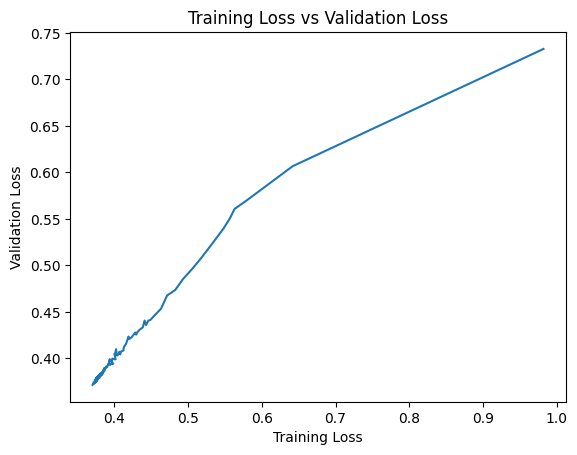

In [17]:
training_data = pd.read_csv(model_filepath+model_name+'.csv')
sns.lineplot(data=training_data, x='Training Loss', y='Validation Loss', sort=False)
plt.title('Training Loss vs Validation Loss')
plt.show()

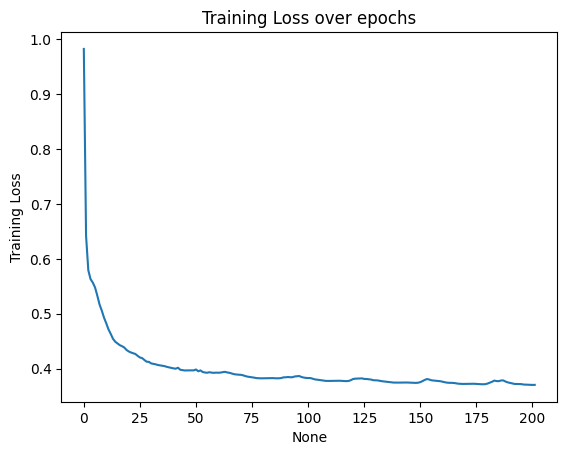

In [18]:
training_data = pd.read_csv(model_filepath+model_name+'.csv')
sns.lineplot(data=training_data, x=training_data.index, y='Training Loss', sort=False)
plt.title('Training Loss over epochs')
plt.show()

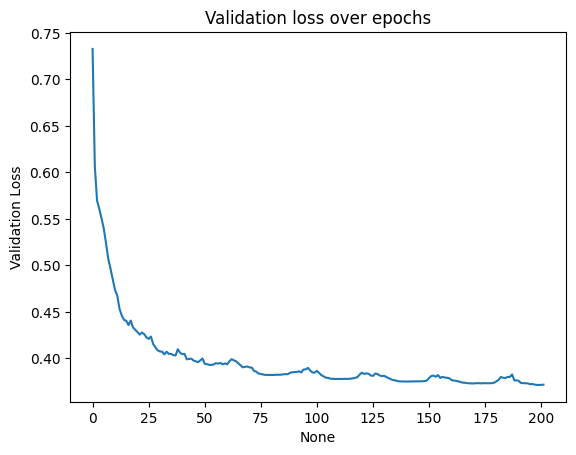

In [19]:
training_data = pd.read_csv(model_filepath+model_name+'.csv')
sns.lineplot(data=training_data, x=training_data.index, y='Validation Loss', sort=False)
plt.title('Validation loss over epochs')
plt.show()

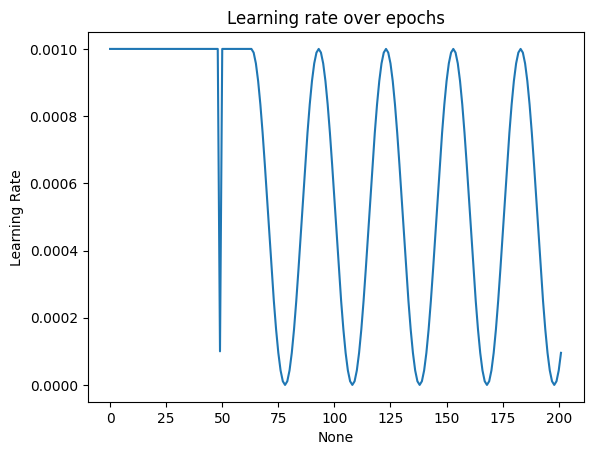

In [20]:
training_data = pd.read_csv(model_filepath+model_name+'.csv')
sns.lineplot(data=training_data, x=training_data.index, y='Learning Rate', sort=False)
plt.title('Learning rate over epochs')
plt.show()

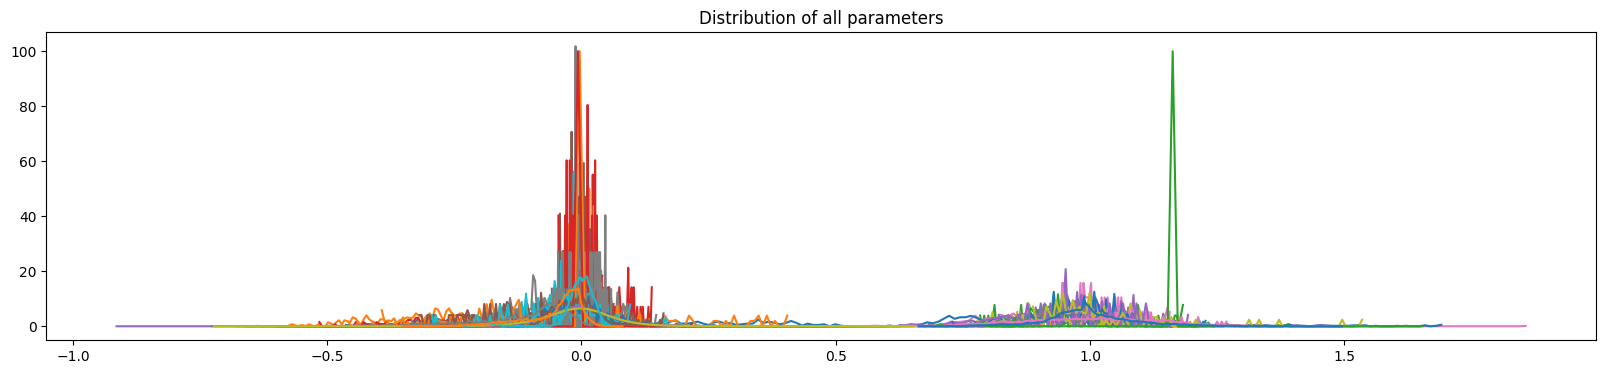

In [21]:
plt.figure(figsize=(20, 4)) # width and height of the plot

legends = []
for i, p in enumerate(conv_ae.parameters()):
    t = p.cpu()
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
plt.title('Distribution of all parameters');

name: encoders.0.1.weight Shape: torch.Size([64]) Mean: 0.9781014323234558, Std: 0.10790280997753143, saturated: 50.0
name: encoders.0.4.weight Shape: torch.Size([64]) Mean: 0.9971997737884521, Std: 0.0541766881942749, saturated: 68.75
name: encoders.1.1.weight Shape: torch.Size([128]) Mean: 0.9934070706367493, Std: 0.07297272980213165, saturated: 60.9375
name: encoders.1.4.weight Shape: torch.Size([128]) Mean: 0.9888308048248291, Std: 0.06526418775320053, saturated: 58.59375
name: encoders.2.1.weight Shape: torch.Size([256]) Mean: 0.9591447710990906, Std: 0.08788279443979263, saturated: 48.046875
name: encoders.2.4.weight Shape: torch.Size([256]) Mean: 0.9602075219154358, Std: 0.11138902604579926, saturated: 46.875
name: encoders.3.1.weight Shape: torch.Size([512]) Mean: 0.942874550819397, Std: 0.1756574809551239, saturated: 34.5703125
name: encoders.3.4.weight Shape: torch.Size([512]) Mean: 0.9173712134361267, Std: 0.21261057257652283, saturated: 27.1484375
name: decoders.0.1.weight 

C:\Users\arthu\AppData\Local\Temp\ipykernel_21776\1795396973.py:5: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  print(f'name: {name} Shape: {t.shape} Mean: {t.mean()}, Std: {t.std()}, saturated: {saturated}')


name: fc.1.weight Shape: torch.Size([8192]) Mean: 1.0044004917144775, Std: 0.09016864001750946, saturated: 67.05322265625


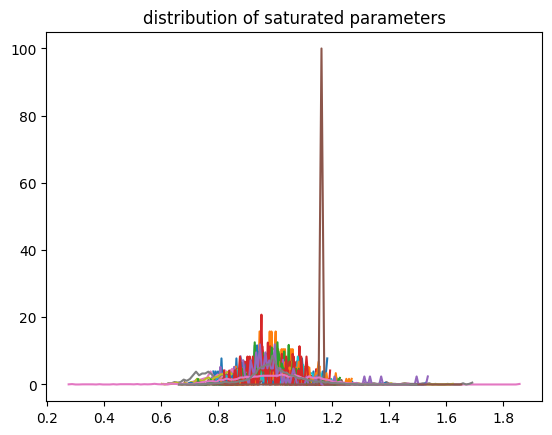

In [22]:
for name, param in conv_ae.named_parameters():
    t = param.cpu()
    saturated = (t.abs() > 0.97).float().mean()*100
    if saturated > 0.0:
        print(f'name: {name} Shape: {t.shape} Mean: {t.mean()}, Std: {t.std()}, saturated: {saturated}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
plt.title('distribution of saturated parameters');


name: encoders.0.3.bias Shape: torch.Size([64]) Mean: -0.007649094797670841, Std: 0.03222028166055679, saturated: 0.0
name: encoders.1.0.bias Shape: torch.Size([128]) Mean: -0.004181188996881247, Std: 0.028927311301231384, saturated: 0.0
name: encoders.1.3.bias Shape: torch.Size([128]) Mean: -0.00226973881945014, Std: 0.021202336996793747, saturated: 0.0
name: encoders.2.0.bias Shape: torch.Size([256]) Mean: -0.0016211217734962702, Std: 0.021876174956560135, saturated: 0.0
name: encoders.2.3.bias Shape: torch.Size([256]) Mean: -0.0013051407877355814, Std: 0.01661158725619316, saturated: 0.0
name: encoders.3.0.bias Shape: torch.Size([512]) Mean: 0.00045792863238602877, Std: 0.01475407462567091, saturated: 0.0
name: encoders.3.3.bias Shape: torch.Size([512]) Mean: 0.0002818211796693504, Std: 0.011990330182015896, saturated: 0.0
name: decoders.0.0.bias Shape: torch.Size([512]) Mean: -2.3961212718859315e-05, Std: 0.012295850552618504, saturated: 0.0
name: decoders.0.3.bias Shape: torch.Siz

C:\Users\arthu\AppData\Local\Temp\ipykernel_21776\2010225207.py:4: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  if t.std() < 0.05:


name: fc.0.bias Shape: torch.Size([8192]) Mean: -0.005736543331295252, Std: 0.04386531561613083, saturated: 0.0


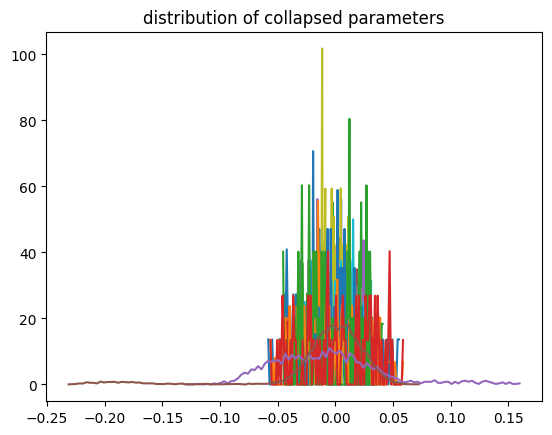

In [23]:
for name, param in conv_ae.named_parameters():
    t = param.cpu()
    saturated = (t.abs() > 0.97).float().mean()*100
    if t.std() < 0.05:
        print(f'name: {name} Shape: {t.shape} Mean: {t.mean()}, Std: {t.std()}, saturated: {saturated}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
plt.title('distribution of collapsed parameters');

In [17]:
with torch.no_grad():
    sample_input = frames_trainset.__getitem__(0)[0].unsqueeze(0).to(device)
sample_input.shape

torch.Size([1, 1, 129, 5])

In [22]:
# set log_stats flag to true to log activation statistics for each module
conv_ae.log_stats = True
with torch.no_grad():
    sample_output = conv_ae(sample_input)
conv_ae.log_stats = False
sample_output, sample_output.shape

(tensor([[[[0.0000e+00, 0.0000e+00, 3.7057e-01, 4.6624e-01, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 7.4848e-01, 3.1600e-01, 1.3604e-01],
           [0.0000e+00, 0.0000e+00, 1.1264e+00, 1.6576e-01, 2.7207e-01],
           [0.0000e+00, 0.0000e+00, 8.7717e-01, 8.4270e-02, 4.0525e-01],
           [0.0000e+00, 0.0000e+00, 6.0738e-01, 5.0310e-03, 5.3834e-01],
           [0.0000e+00, 0.0000e+00, 9.2429e-01, 2.4305e-01, 4.9191e-01],
           [0.0000e+00, 0.0000e+00, 1.2810e+00, 5.0258e-01, 4.3330e-01],
           [0.0000e+00, 0.0000e+00, 1.3205e+00, 5.7904e-01, 3.8668e-01],
           [0.0000e+00, 0.0000e+00, 1.3266e+00, 6.3624e-01, 3.4133e-01],
           [0.0000e+00, 0.0000e+00, 1.1576e+00, 6.4277e-01, 3.3261e-01],
           [0.0000e+00, 0.0000e+00, 9.6320e-01, 6.4194e-01, 3.2922e-01],
           [0.0000e+00, 0.0000e+00, 8.2434e-01, 6.3328e-01, 1.9259e-01],
           [0.0000e+00, 0.0000e+00, 6.9597e-01, 6.2315e-01, 3.0814e-02],
           [0.0000e+00, 0.0000e+00, 7.2169e-01, 6.1

In [23]:
with torch.no_grad():
    loss = loss_function(sample_input, sample_output, red='mean')
loss

tensor(1.1090, device='cuda:0')

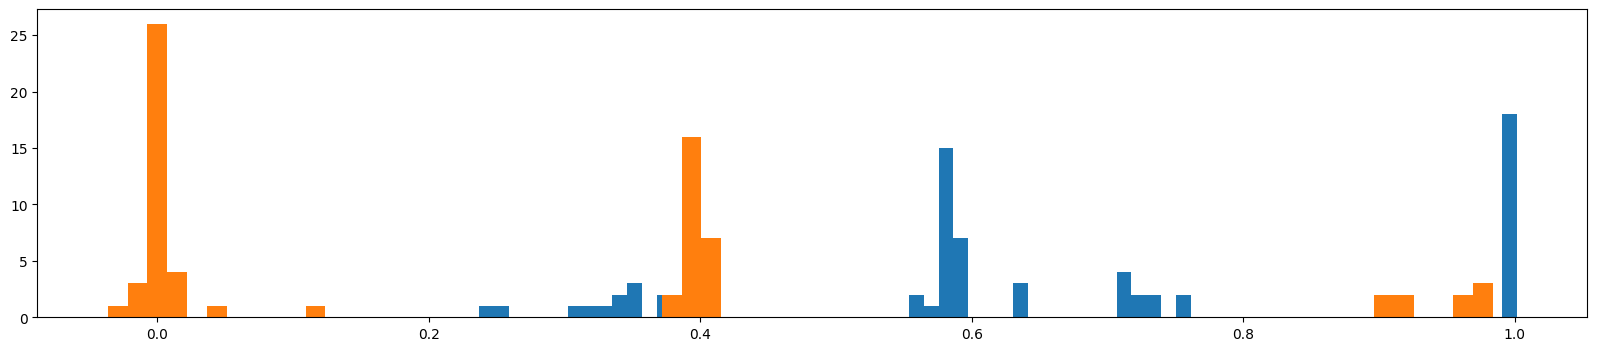

In [24]:
# accessing activation statistics saved to activation_stats by the forward hook
plt.figure(figsize=(20, 4))
s = []
m = []
for module, stats in activation_stats.items():
    s.append(stats['std'])
    m.append(stats['mean'])

plt.hist(s, len(s), label='Std of preactivations'); #  blue
plt.hist(m, len(m), label='Mean of preactivations'); # orange
